 This Python 3 environment comes with many helpful analytics libraries installed
 It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
 For example, here's several helpful packages to load in
 another ref that you can use is : https://github.com/glample/tagger/blob/master/model.py

In [12]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

os.chdir("/home/jovyan/work/LSTM")
import lstmFun

In [16]:
from subprocess import check_output
print(check_output(["ls", "/home/jovyan/work/data/label_data"]).decode("utf8"))

digitoday.2014.csv
digitoday.2014.dev.csv
digitoday.2014.train.csv
digitoday.2015.test.csv
ner.csv
ner-origin.csv



In [19]:
dframe = pd.read_csv("/home/jovyan/work/data/label_data/ner.csv", encoding = "ISO-8859-1")
# dframe = pd.read_csv("/home/jovyan/work/data/label_data/digitoday.2014.train.csv",on_bad_lines='skip',delimiter='\t',names=['word', 'tag', 'unnamed'])
dframe.head(30)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [20]:

dframe = lstmFun.add_sentence_id_column(dframe)

KeyError: 'word'

In [12]:
sentences, get_next = lstmFun.get_sentences(dframe)

In [13]:
maxlen = lstmFun.get_max_len(sentences)
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 140


In [14]:
# Check how long sentences are so that we can pad them
plt.style.use("ggplot")

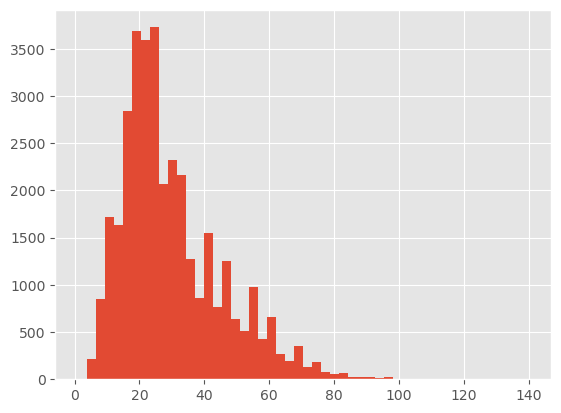

In [15]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [16]:
words = list(set(dframe["word"].values))
words.append("ENDPAD")

In [17]:
n_words = len(words); n_words

30173

In [18]:
tags = list(set(dframe["tag"].values))
tags

['B-geo',
 'I-tim',
 'I-org',
 'B-gpe',
 'I-per',
 'B-eve',
 'O',
 'B-tim',
 nan,
 'B-art',
 'I-art',
 'I-gpe',
 'B-per',
 'I-nat',
 'I-geo',
 'B-org',
 'I-eve',
 'B-nat']

In [19]:
n_tags = len(tags); n_tags

18

In [20]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [21]:
word2idx['Obama']

14560

In [22]:
tag2idx["O"]

6

In [23]:
# import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

2023-05-21 17:53:51.116764: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-21 17:53:51.166420: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-21 17:53:51.449916: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-21 17:53:51.451612: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 17:53:54.269854: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [24]:
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [25]:
X = pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)

In [26]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]

In [27]:
y = pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["O"])

In [28]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [94]:
# from collections import Counter
#
# tag_counts = Counter(tag for sentence_tags in y_train for tag in sentence_tags)
RevWord = {i: t for t, i in word2idx.items()}
RevY = {i: t for t, i in tag2idx.items()}
# reversed_y = [[RevY[idx] for idx in sentence_tags] for sentence_tags in y]
reversed_y = [[RevY[tuple(arr)] for arr in sentence_tags] for sentence_tags in y]


reversed_y


# Count the occurrences of each tag
# tag_counts = Counter(tag_counts)
#
# # Print the counts per tag
# for tag, count in tag_counts.items():
#     print(tag)
#     print(count)
#     print()

KeyError: (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)

In [30]:
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [31]:
input = Input(shape=(maxlen,))
model = Embedding(input_dim=n_words, output_dim=maxlen, input_length=maxlen)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

In [32]:
model = Model(input, out)

In [33]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
# TODO CHECK THE LEARNING RATE FOR THE ADAM OPTIMISER!!!!

In [34]:
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=1, validation_split=0.2, verbose=1)

704/704 [==============================] - 221s 299ms/step - loss: 0.1293 - accuracy: 0.9749 - val_loss: 0.0434 - val_accuracy: 0.9889


In [35]:
dir = "/home/jovyan/work/data/output/LSTMmodel"
model.save(dir)

2023-05-21 17:57:42.909062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'while/Placeholder_2' with dtype float and shape [?,100]
	 [[{{node while/Placeholder_2}}]]
2023-05-21 17:57:42.974277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'while/Placeholder_2' with dtype float and shape [?,100]
	 [[{{node while/Placeholder_2}}]]
2023-05-21 17:57:42.993123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and 

INFO:tensorflow:Assets written to: /home/jovyan/work/data/output/LSTMmodel/assets


INFO:tensorflow:Assets written to: /home/jovyan/work/data/output/LSTMmodel/assets


In [36]:
i = 0
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:14} ({:5}): {}".format("Word", "True", "Pred"))
for w,pred in zip(X_test[i],p[0]):
    print("{:14}: {}".format(words[w],tags[pred]))

1/1 [==============================] - 0s 428ms/step
Word           (True ): Pred
Bermuda       : B-org
's            : O
tourism       : O
industry      : O
-             : O
which         : O
derives       : O
over          : O
80            : O
%             : O
of            : O
its           : O
visitors      : O
from          : O
the           : O
US            : B-geo
-             : O
continues     : O
to            : O
struggle      : O
but           : O
remains       : O
the           : O
island        : O
's            : O
number        : O
two           : O
industry      : O
.             : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD    

In [37]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 140)]             0         
                                                                 
 embedding (Embedding)       (None, 140, 140)          4224220   
                                                                 
 dropout (Dropout)           (None, 140, 140)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 140, 200)         192800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 140, 18)          3618      
 ibuted)                                                         
                                                                 
Total params: 4,420,638
Trainable params: 4,420,638
Non-train

In [38]:
# Evaluation
loss, accuracy = model.evaluate(X_test, np.array(y_test))
print("Loss: {:.4f}".format(loss))
print("Accuracy: {:.2f}%".format(accuracy * 100))

220/220 [==============================] - 8s 36ms/step - loss: 0.0448 - accuracy: 0.9883
Loss: 0.0448
Accuracy: 98.83%


In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [77]:

y_pred = model.predict(X_test)
y_pred_indices = np.argmax(y_pred, axis=-1)

# Flatten the true and predicted labels
y_true_flattened = np.argmax(y_test, axis=-1).flatten()
y_pred_flattened = y_pred_indices.flatten()


# Calculate F1 score
f1 = f1_score(y_true_flattened, y_pred_flattened, average='weighted')

# Calculate accuracy
accuracy = accuracy_score(y_true_flattened, y_pred_flattened)

# Print the evaluation metrics
print("F1 Score:", f1)
print("Accuracy:", accuracy)

220/220 [==============================] - 8s 35ms/step
F1 Score: 0.9876285678476161
Accuracy: 0.988345650938033


In [82]:
from sklearn.metrics import precision_recall_fscore_support

# Get the predicted labels
y_pred = model.predict(X_test)
y_pred_indices = np.argmax(y_pred, axis=-1)
y_train_indices = np.argmax(y_train, axis=-1)

y_true_flattened = np.argmax(y_test, axis=-1).flatten()
y_pred_flattened = y_pred_indices.flatten()
Y_train_flatten = y_train_indices.flatten()

# Get the list of unique tags
unique_tags = list(set(tags))


# Initialize dictionaries to store evaluation metrics per tag
precision_per_tag = {}
recall_per_tag = {}
f1_per_tag = {}
accuracy_per_tag = {}

# Calculate evaluation metrics for each tag
for tag in unique_tags:

    num = Y_train_flatten[Y_train_flatten == tag].shape
    print (num, tag)
    y_true_tag = y_true_flattened[y_true_flattened == tag]
    y_pred_tag = y_pred_flattened[y_pred_flattened == tag]
    #
    mask = (y_true_flattened == tag2idx[tag])
    y_true_tag = y_true_flattened[mask]
    y_pred_tag = y_pred_flattened[mask]


    # Calculate F1 score
    f1 = f1_score(y_true_tag, y_pred_tag, average='weighted')

    # Calculate accuracy
    accuracy = accuracy_score(y_true_tag, y_pred_tag)

    f1_per_tag[tag] = f1
    accuracy_per_tag[tag] = accuracy

# Print the evaluation metrics per tag
for tag in unique_tags:
    print("Tag:", tag)
    print("F1 Score:", f1_per_tag[tag])
    print("Accuracy:", accuracy_per_tag[tag])
    print()


220/220 [==============================] - 8s 36ms/step


/tmp/ipykernel_73/3090533424.py:25: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  num = Y_train_flatten[Y_train_flatten == tag].shape
/tmp/ipykernel_73/3090533424.py:27: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  y_true_tag = y_true_flattened[y_true_flattened == tag]
/tmp/ipykernel_73/3090533424.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  y_pred_tag = y_pred_flattened[y_pred_flattened == tag]
/tmp/ipykernel_73/3090533424.py:25: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  num = Y_train_flatten[Y_train_flatten == tag].shape
/tmp/ipykernel_73/3090533424.py:27: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will

(0, 3939740) B-geo
(0, 3939740) I-tim
(0, 3939740) I-org
(0, 3939740) B-gpe
(0, 3939740) I-per
(0, 3939740) B-eve
(0, 3939740) O
(0, 3939740) B-tim
(0,) nan
(0, 3939740) B-art
(0, 3939740) I-art
(0, 3939740) I-gpe
(0, 3939740) B-per
(0, 3939740) I-nat
(0, 3939740) I-geo
(0, 3939740) B-org
(0, 3939740) I-eve
(0, 3939740) B-nat
Tag: B-geo
F1 Score: 0.896799238262653
Accuracy: 0.8129066525029877

Tag: I-tim
F1 Score: 0.4174813110983324
Accuracy: 0.26380813953488375

Tag: I-org
F1 Score: 0.8031088082901554
Accuracy: 0.670995670995671

Tag: B-gpe
F1 Score: 0.9128781616796166
Accuracy: 0.8397201946472019

Tag: I-per
F1 Score: 0.8775446288756655
Accuracy: 0.7818080357142857

Tag: B-eve
F1 Score: 0.0
Accuracy: 0.0

Tag: O
F1 Score: 0.9993423920750891
Accuracy: 0.9986856484781552

Tag: B-tim
F1 Score: 0.8506761565836299
Accuracy: 0.7401535793906366

Tag: nan
F1 Score: 0.0
Accuracy: nan

Tag: B-art
F1 Score: 0.0
Accuracy: 0.0

Tag: I-art
F1 Score: 0.0
Accuracy: 0.0

Tag: I-gpe
F1 Score: 0.0
Accu

/tmp/ipykernel_73/3090533424.py:25: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  num = Y_train_flatten[Y_train_flatten == tag].shape
/tmp/ipykernel_73/3090533424.py:27: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  y_true_tag = y_true_flattened[y_true_flattened == tag]
/tmp/ipykernel_73/3090533424.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  y_pred_tag = y_pred_flattened[y_pred_flattened == tag]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_73/3090533424.py:25: 

In [ ]:
from collections import Counter
# Assuming 'tags' is the list of tags for training examples
tags = dframe["tag"].tolist()
tag_counts = Counter(tags)

# Printing the number of training values for each tag
for tag, count in tag_counts.items():
    print(f"Tag: {tag}\tCount: {count}")


In [ ]:
from collections import Counter
import numpy as np

# Flatten the numpy arrays in y_train
tags = [tag for sentence in y_train for tag in np.ravel(sentence)]

tag_counts = Counter(tags)

# Printing the number of training values for each tag
for tag, count in tag_counts.items():
    print(f"Tag: {tag}\tCount: {count}")